In [2]:
# cl_args={
#     'cfg_path':'configs/cut.yaml',
#     'data_dir': "Semantic-CARLA/CARLA_Lidar/projected",
#     'data_dir_B':"/home/joaquinecc/ailivesim/datasets/semantic_kitti/dataset",
#     'batch_size':2,
#     'load':None,
#     'test':False,
#     'ref_dataset_name':'kitti',
#     'norm_label': True,
#     'on_real': False

# }
# print(f"python train.py", end='')
# for key,val in  cl_args.items():
#     print(f" --{key} {val} ", end='')
# import matplotlib.pyplot as plt
# from util.fid import FID
# import tqdm
import  matplotlib.pyplot as plt
from models import create_model
from util.visualizer import Visualizer
from dataset.datahandler import get_data_loader
import numpy as np
import torch
from importlib import reload
import os
from util.lidar import LiDAR
import yaml
from train import make_class_from_dict,M_parser, inv_to_xyz
import random
from collections import defaultdict


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:

class DotDict:
    def __init__(self, **entries):
        self.__dict__.update(entries)

# Convert dictionary to a DotDict instance
cl_args={
    'cfg_path':'configs/cut.yaml',
    'data_dir': "Semantic-CARLA/CARLA_Lidar/projected",
    'data_dir_B':"/home/joaquinecc/ailivesim/datasets/semantic_kitti/dataset",
    'batch_size':1,
    'load':None,
    'test':False,
    'ref_dataset_name':None,
    'norm_label': True,
    'on_real': False
}
cl_args = DotDict(**cl_args)
opt = M_parser(cl_args.cfg_path, cl_args.data_dir,cl_args.data_dir_B, cl_args.load, cl_args.test, cl_args.batch_size)
if cl_args.on_real:
    opt= cl_args.ref_dataset_name
opt.model.norm_label = cl_args.norm_label
# opt.training.n_epochs = 1
torch.manual_seed(opt.training.seed)
np.random.seed(opt.training.seed)
random.seed(opt.training.seed)
is_two_dataset = False
if hasattr(opt.dataset, 'dataset_B'):
    is_two_dataset = True
device = torch.device('cuda:0') 


In [4]:
ds_cfg = make_class_from_dict(yaml.safe_load(open(f'configs/dataset_cfg/{opt.dataset.dataset_A.name}_cfg.yml', 'r')))
lidar_A = LiDAR(
cfg=ds_cfg,
height=opt.dataset.dataset_A.img_prop.height,
width=opt.dataset.dataset_A.img_prop.width).to(device)

ds_cfg_B = make_class_from_dict(yaml.safe_load(open(f'configs/dataset_cfg/{opt.dataset.dataset_B.name}_cfg.yml', 'r')))
lidar_B = LiDAR(
cfg=ds_cfg_B,
height=opt.dataset.dataset_B.img_prop.height,
width=opt.dataset.dataset_B.img_prop.width,
).to(device)

/home/joaquinecc/miniconda3/envs/coligen2/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [5]:
visualizer = Visualizer(opt)   # create a visualizer that display/save images and plots
g_steps = 0
min_fid = 10000
# if cl_args.ref_dataset_name == 'kitti':
#     ignore_label = [0, 2, 3, 4, 5, 7, 8, 10, 12, 16]
# elif cl_args.ref_dataset_name == 'semanticPOSS':
#     ignore_label = [0, 3, 9]
# is_ref_semposs = cl_args.ref_dataset_name == 'semanticPOSS'
is_ref_semposs=False
train_dl, train_dataset = get_data_loader(opt, 'train', opt.training.batch_size,is_ref_semposs=is_ref_semposs)
val_dl, val_dataset = get_data_loader(opt, 'val' , opt.training.batch_size, shuffle=False, is_ref_semposs=is_ref_semposs)  
# test_dl, test_dataset = get_data_loader(opt, 'test', opt.training.batch_size, dataset_name=cl_args.ref_dataset_name, two_dataset_enabled=False, is_ref_semposs=is_ref_semposs)
   

In [6]:
model = create_model(opt, lidar_A, lidar_B)
#First FOWARD
train_dl_iter=iter(train_dl)
data=next(train_dl_iter)
model.set_input(data)        
#SET pathcLoss Network
model.data_dependent_initialize(data) #Set up the PatchNetwork
# model.optimize_parameters()  
model.setup(opt.training)


initialize network with xavier
initialize network with xavier
initialize network with xavier
initialize network with xavier
model [CUTModel] was created
initialize network with xavier
---------- Networks initialized -------------
DataParallel(
  (module): ResnetGenerator(
    (gumbel): GumbelSigmoid(hard=True, eps=1e-10)
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(2, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Downsample(
        (pad): ReflectionPad2d([1, 1, 1, 1])
      )
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=Fa

/home/joaquinecc/ailivesim/CoLiGen/models/networks.py:611: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch_id = torch.tensor(patch_id, dtype=torch.long, device=feat.device)


In [7]:
for epoch in range(0, 1):  # inner loop within one epoch
    e_steps = 0      
    model.train(True)
    train_dl_iter = iter(train_dl)
    n_train_batch = 2 
    for i in range(n_train_batch):
        data = next(train_dl_iter)
        g_steps += 1
        e_steps += 1
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights
        if g_steps % opt.training.display_freq == 0:   # display images on visdom and save images to a HTML file
            current_visuals = model.get_current_visuals()
            visualizer.display_current_results('train',current_visuals, g_steps,ds_cfg, opt.dataset.dataset_A.name, lidar_A, ds_cfg_B,\
                    opt.dataset.dataset_B.name,lidar_B)

        if g_steps % opt.training.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            # visualizer.print_current_losses('train', epoch, e_steps, losses, train_tq)
            visualizer.plot_current_losses('train', epoch, losses, g_steps)


In [8]:
model.get_current_visuals()

OrderedDict([('real_inv',
              tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
                        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
                        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
                        ...,
                        [-0.0354, -0.0354, -0.0355,  ..., -0.0356, -0.0355, -0.0354],
                        [-0.0227, -0.0227, -0.0228,  ..., -0.0228, -0.0228, -0.0226],
                        [ 0.0026,  0.0026,  0.0026,  ...,  0.0025,  0.0026,  0.0027]]]],
                     device='cuda:0')),
             ('real_reflectance',
              tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
                        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
                        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
                        ...,
                        [ 0.8799,  0.8799,  0.8798,  ...,  0.8798

In [10]:
model.synth_inv.shape

torch.Size([1, 1, 64, 2048])

In [22]:
a = model.synth_inv.reshape(64,2048)
a=1/a
a.shape,a

(torch.Size([64, 2048]),
 tensor([[ 361.6851,  178.6518,  282.0076,  ..., -654.0336,  -78.4559,
           -82.4497],
         [ 139.4881,   99.4343,  152.3266,  ...,  821.5734, -116.4664,
          -118.7793],
         [ 409.0083,  203.0014,  409.0659,  ..., -216.9322,  -66.7927,
           -76.0668],
         ...,
         [   6.6776,    6.8029,    6.3675,  ...,    7.5361,    9.3703,
             9.8203],
         [   6.7793,    6.9910,    6.3949,  ...,    8.1088,    9.8076,
            10.8120],
         [   8.1588,    7.9137,    7.0306,  ...,    9.5740,   12.3065,
            13.3573]], device='cuda:0', grad_fn=<MulBackward0>))

/tmp/ipykernel_12943/2843293666.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(a.detach().cpu().numpy()))


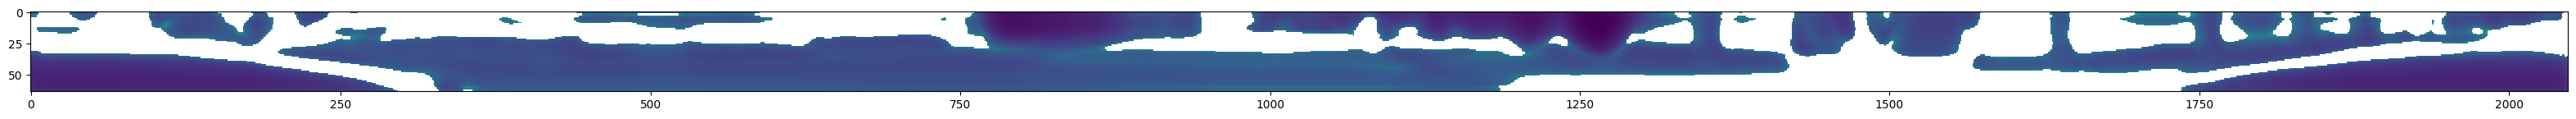

In [ ]:
plt.figure(figsize=(20*2,15*2))
plt.imshow(np.log(a.detach().cpu().numpy()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


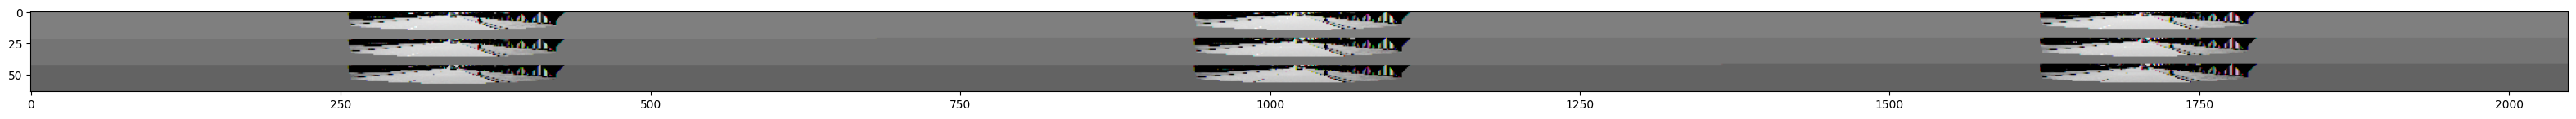

In [31]:
b= model.real_rgb.reshape(64,2048,3)
plt.figure(figsize=(20*2,15*2))
plt.imshow(b.detach().cpu().numpy())

In [ ]:
data['A']['path']


In [ ]:
data['A']['points'].shape

In [ ]:
test_image_results = defaultdict(list)
n_pics=0
vis_dict = model.get_current_visuals()
for k, v in vis_dict.items():
    test_image_results[k].append(v.cpu().detach().numpy())
    n_pics += v.shape[0]
test_image_results = {k: np.concatenate(v, axis=0) for k, v in test_image_results.items()}


In [ ]:
test_image_results.keys()

In [ ]:
test_image_results['real_B_rgb'].shape

In [ ]:
test_image_results['real_inv'].shape

In [ ]:
a= test_image_results['real_rgb'][0]
a= a.reshape(256,256,3)

In [ ]:
plt.figure(figsize=(20,15))
plt.imshow(a)

In [ ]:
inv_to_xyz(synth_inv,lidar_A).shape

In [ ]:
from util import *
from PIL import Image

In [ ]:
synth_depth = lidar_B.revert_depth(tanh_to_sigmoid(synth_inv), norm=False)
synth_points = lidar_B.inv_to_xyz(tanh_to_sigmoid(synth_inv)) * lidar_B.max_depth
synth_reflectance = tanh_to_sigmoid(synth_reflectance)
synth_data = torch.cat([synth_depth, synth_points, synth_reflectance], dim=1)
fetched_data = fetch_reals(data['A'], lidar_A, device, opt.model.norm_label)
synth_depth.shape

In [ ]:
synth_depth

In [ ]:
fetched_data_path, label_tensor = fetched_data['path'], fetched_data['lwo'] * synth_mask


In [ ]:
    _colors = cm.turbo(np.asarray(range(_n_classes)) / (_n_classes - 1))[:, :3] * 255

for f_d, s_d, l_t in zip(fetched_data_path, synth_data, label_tensor):
    labels = Image.fromarray(l_t.squeeze().cpu().numpy().astype('uint8'), mode="P")
    palette = list(np.uint8(_colors).flatten())


In [ ]:
s_d.shape